In [24]:
import pandas as pd  
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
 
pd.set_option('display.max_columns', None) # display all columns
pd.set_option("max_colwidth", 40) # sets a maximum column width
pd.set_option("display.precision", 7) # sets the number of decimals shown
pd.set_option("styler.format.precision", 3) # rounds floats

df = pd.read_csv('../data/country-data.csv')
numerical_features = df.columns[1:]
countries = df['country']

df_pca = pd.read_csv('../data/country-data-pca.csv')

# DBSCAN Clustering algorithm

DBSCAN works as following:
- For each instance in the data, the algorithm counts how many instances are located within a small distance $\epsilon$ (epsilon) from it. So, in 3-dimensional space, that would be the radius a sphere.
- If an instance has at least `min_samples` instances in its $\epsilon$-neighborhood (including itself), then it is considered a *core instance*. In other words; core instances are those that are located in dense regions.
- All instances in the neighborhood of a core instance belong to the same cluster. This neighborhood may include other core instances; therefore, a long sequence of neighboring core instances forms a single cluster.
- Any instance that is not a core instance and does not have one in its neighborhood is considered an anomaly.
  

In [12]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from collections import Counter, OrderedDict
from sklearn.preprocessing import MinMaxScaler

In [33]:
features = df.columns
scaler = MinMaxScaler()

scaled_raw_df = pd.DataFrame(scaler.fit_transform(df[numerical_features]))
scaled_raw_df.columns = features[1:]

scaled_pca_df = pd.DataFrame(scaler.fit_transform(df_pca[['PC1', 'PC2', 'PC3', 'PC4']]))
scaled_pca_df.columns = ['PC1', 'PC2', 'PC3', 'PC4']

In [97]:
dbscan = DBSCAN(eps=0.08, min_samples=4) 
dbscan.fit(scaled_pca_df)

labels = dbscan.labels_ # cluster labels for each country
core_indices = dbscan.core_sample_indices_ # indices of the core samples
n_core = len(core_indices) # number of countries considered a "core" samples
number_of_anomalies = len([x for x in labels if x == -1]) # number of countries considered an "outlier"
number_of_clusters = len(set(labels)) - (1 if -1 in labels else 0) # number of clusters
n_points_clusters = OrderedDict(Counter(sorted(labels)))
components = dbscan.components_ # values of the core samples

print("Labels:\n", labels)
print("Core indices:\n", core_indices)
print(n_core, "core samples")
print(number_of_anomalies, "anomalies")
print(number_of_clusters, "clusters")
print(n_points_clusters, "points distribution")

anomaly_countries = []
for i in range(len(labels)):
    if labels[i] == -1:
        anomaly_countries.append(countries[i])

Labels:
 [ 0  1  1 -1  1  1  1 -1 -1  1 -1 -1  1  1  1 -1  1  0  1  1  3 -1  1 -1
  1  0 -1  1  0 -1  1 -1 -1  1  1  1  0 -1 -1  3  0  1 -1 -1 -1  1  1  1
  1 -1 -1  1  1  2 -1 -1  0  3 -1  0 -1  1  1  0  0  1 -1  1  2  1  1  1
 -1 -1 -1  2  1 -1 -1 -1  0 -1 -1  1  1  1  1 -1 -1 -1  1 -1  1  0  0 -1
  1 -1 -1 -1  1 -1 -1  1  3  1  0 -1 -1  1 -1  2 -1 -1 -1 -1 -1 -1  1  1
  1  1 -1 -1  1  1 -1  1 -1  0  3 -1 -1 -1 -1 -1 -1 -1 -1  2 -1  1 -1  1
  2 -1  1  0 -1 -1 -1  1  1  1 -1  0  1 -1  2 -1  1  1  1 -1 -1  0  0]
Core indices:
 [  0   1   4   6   9  12  13  14  16  17  18  19  24  27  28  30  33  34
  35  36  41  45  47  52  53  56  59  61  63  65  69  71  75  76  80  85
  86  90  92  93  94  96 100 103 105 106 109 118 119 121 124 125 127 129
 130 141 147 151 152 153 156 158 160 161 162 165 166]
67 core samples
74 anomalies
4 clusters
OrderedDict([(-1, 74), (0, 19), (1, 62), (2, 7), (3, 5)]) points distribution


In [50]:
for i in range(-1, number_of_clusters):
    print("Cluster", i, "\n")
    for j in range(len(labels)):
        if labels[j] == i:
            print(countries[j])

Cluster -1 

Angola
Australia
Austria
Bahamas
Bahrain
Belgium
Botswana
Brunei
Burundi
Canada
Central African Republic
Chad
Congo, Dem. Rep.
Congo, Rep.
Cyprus
Czech Republic
Denmark
Equatorial Guinea
Eritrea
France
Gabon
Germany
Greece
Haiti
Iraq
Ireland
Israel
Japan
Jordan
Kazakhstan
Kiribati
Kuwait
Lesotho
Liberia
Libya
Luxembourg
Malaysia
Mali
Malta
Mauritania
Micronesia, Fed. Sts.
Moldova
Myanmar
Namibia
Netherlands
Niger
Nigeria
Norway
Oman
Pakistan
Panama
Portugal
Qatar
Rwanda
Saudi Arabia
Seychelles
Sierra Leone
Singapore
Slovak Republic
Slovenia
Solomon Islands
South Africa
South Korea
Sri Lanka
Sudan
Switzerland
Thailand
Timor-Leste
Togo
Turkmenistan
United Arab Emirates
United States
Venezuela
Vietnam
Cluster 0 

Afghanistan
Benin
Burkina Faso
Cameroon
Comoros
Cote d'Ivoire
Gambia
Ghana
Guinea
Guinea-Bissau
Kenya
Madagascar
Malawi
Mozambique
Senegal
Tanzania
Uganda
Yemen
Zambia
Cluster 1 

Albania
Algeria
Antigua and Barbuda
Argentina
Armenia
Azerbaijan
Bangladesh
Barbados
Be

## Determine the optimal value for $\epsilon$

Source:
https://towardsdatascience.com/machine-learning-clustering-dbscan-determine-the-optimal-value-for-epsilon-eps-python-example-3100091cfbc

To determine a a good value for $\epsilon$, we find a suitable value for $\epsilon$ by calculating the distance to the nearest $n$ points for each point, sorting and plotting the results. Then we look to see where the change is most pronounced and select that as $\epsilon$.

we can calculate the distance from each point to its closest neighbour using the `NearestNeighbors`. The point itself is included in `n_neighbors`. The `kneighbors` method returns two arrays, one which contains the distance to the closest `n_neighbors` points and the other which contains the index for each of those points.

In [58]:
from sklearn.neighbors import NearestNeighbors

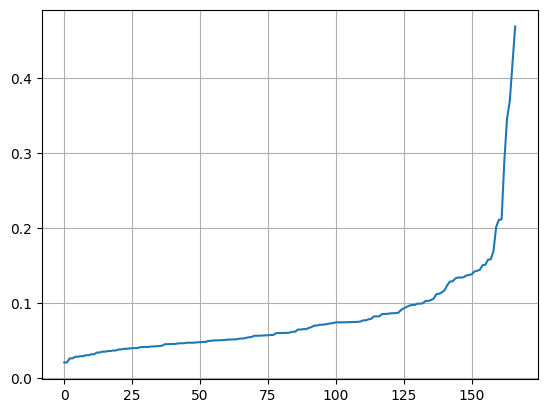

In [94]:
neigh = NearestNeighbors(n_neighbors=2) # instanciate NearestNeighbors object
nbrs = neigh.fit(scaled_pca_df) # fit the object to the data
distances, indices = nbrs.kneighbors(scaled_pca_df)
distances = np.sort(distances, axis=0)[:,1] # sort the distances and keep only the second column
plt.plot(distances)
plt.grid()

# HDBSCAN

In [11]:
# TODO Try to implement this to see if we get better results since hierarchical clustering worked well